<b>AB тестирование</b>

Cookie Cats — популярная мобильная игра-головоломка, разработанная компанией Tactile Entertainment. Он соответствует классическому формату головоломки «соедини три», в котором игроки должны совмещать плитки одного цвета, чтобы очистить доску и продвигаться по уровням. Уникальной особенностью игры являются поющие коты.

По мере прохождения игры игроки сталкиваются с блокирующими уровнями (gates), которые требуют от них ожидания или совершения покупок в приложении, чтобы продолжить. Эти уровни служат двойной цели: стимулировать покупки в приложении и давать игрокам передышку, потенциально повышая их общее удовольствие от игры и продлевая их вовлеченность.

Целью этого проекта является анализ AB-теста, проведенного в Cookie Cats, где размещение первого блокирующего уровня было перенесено с уровня 30 на уровень 40. В частности, мы исследуем влияние этого изменения на удержание игроков.

Набор данных включает данные 90189 игроков, которые установили игру во время периода AB-тестирования. Переменные включают в себя:

userid: уникальный идентификатор для каждого игрока.

version: указывает, был ли игрок отнесен к контрольной группе (gate_30 — блок на уровне 30) или тестовой группе (gate_40 — блок на уровне 40).

sum_gamerounds: количество игровых раундов, сыгранных игроком в течение первой недели после установки.

Retention_1: двоичная переменная, указывающая, вернулся ли игрок в игру через день после установки.

Retention_7: двоичная переменная, указывающая, вернулся ли игрок в игру через семь дней после установки.

При установке игроки случайным образом распределялись либо по gate_30, либо по gate_40.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2_contingency

<b>Чтение файла CSV и проверка данных</b>

In [2]:
dataset = pd.read_csv("cookie_cats.csv")
display(dataset.info())
display(dataset.sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


None

,userid,version,sum_gamerounds,retention_1,retention_7
55613,6165848,gate_30,56,True,False
62976,6978859,gate_40,8,False,False
2921,320866,gate_40,48,False,True
83279,9229487,gate_40,5,False,False
5004,555176,gate_30,1,False,False
44904,4975727,gate_40,9,False,False
3654,405217,gate_40,15,False,False
39576,4383537,gate_40,6,False,False
89753,9953244,gate_30,64,True,False
34631,3835228,gate_40,32,True,False


<b>Фильтрация sum_gamerounds > 0 для тех, кто только установил игру, но не играл в нее.</b>

In [3]:
dataset1 = dataset[dataset['sum_gamerounds'] != 0]

print(dataset1)

        userid  version  sum_gamerounds  retention_1  retention_7
0          116  gate_30               3        False        False
1          337  gate_30              38         True        False
2          377  gate_40             165         True        False
3          483  gate_40               1        False        False
4          488  gate_40             179         True         True
...        ...      ...             ...          ...          ...
90184  9999441  gate_40              97         True        False
90185  9999479  gate_40              30        False        False
90186  9999710  gate_30              28         True        False
90187  9999768  gate_40              51         True        False
90188  9999861  gate_40              16        False        False

[86195 rows x 5 columns]


<b>Количество раундов, сыгранных игроками по gate_30 и gate_40</b>

version
gate_30    2344795
gate_40    2333530
Name: sum_gamerounds, dtype: int64


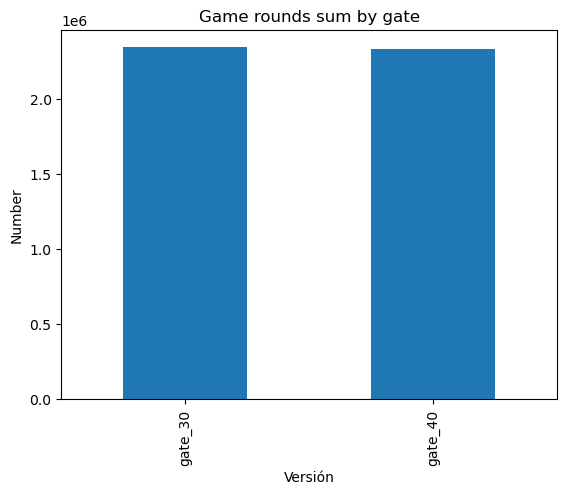

In [4]:
dataset2 = dataset1.groupby('version')['sum_gamerounds'].sum()
print(dataset2)
dataset2.plot(kind='bar', stacked=False)

plt.title('Game rounds sum by gate')
plt.xlabel('Versión')
plt.ylabel('Number')

plt.show()

Как было замечено, между gate_30 и gate_40 есть небольшая разница в сумме раундов, что незначительно.

<b>Retention</b>

In [5]:
counts2 = dataset1.groupby('version')[['retention_1', 'retention_7']].apply(lambda x: x.apply(pd.value_counts)).unstack(fill_value=0)
print(counts2)

        retention_1        retention_7      
              False  True        False True 
version                                     
gate_30       22770  19993       34277  8486
gate_40       23359  20073       35166  8266


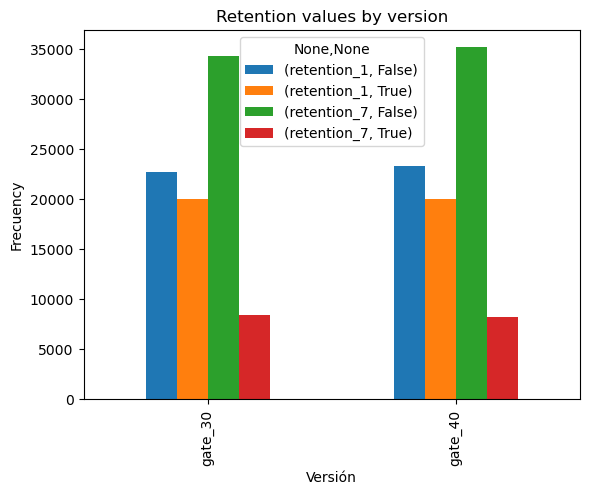

In [6]:
counts2.plot(kind='bar', stacked=False)


plt.title('Retention values by version')
plt.xlabel('Versión')
plt.ylabel('Frecuency')

plt.show()

Наблюдения: Как мы видим, количество удерженных игроков для обеих версий близки. Для gate_30 retention_1 = 19993, а retention_7 = 8486. Для gate_40 retention_1 = 20073, а retention_7 = 8 266.

In [7]:
retention_rate_1 = dataset1.groupby('version')['retention_1'].mean()
retention_rate_7 = dataset1.groupby('version')['retention_7'].mean()


print("retention_rate_1")
print(retention_rate_1)

print("retention_rate_7")
print(retention_rate_7)

retention_rate_1
version
gate_30    0.467530
gate_40    0.462171
Name: retention_1, dtype: float64
retention_rate_7
version
gate_30    0.198443
gate_40    0.190321
Name: retention_7, dtype: float64


Наблюдения: Как мы видим, несмотря на то, что цифры удержания близки, можно увидеть небольшую разницу в показателях, где gate_30 имеют большее число.

<b>Retention gate_30 и gate_40

In [8]:
retention_rate_gate_30_1_day = dataset1.loc[dataset1['version'] == 'gate_30', 'retention_1'].mean()
retention_rate_gate_40_1_day = dataset1.loc[dataset1['version'] == 'gate_40', 'retention_1'].mean()

retention_rate_gate_30_7_days = dataset1.loc[dataset1['version'] == 'gate_30', 'retention_7'].mean()
retention_rate_gate_40_7_days = dataset1.loc[dataset1['version'] == 'gate_40', 'retention_7'].mean()

print("Retention Rate for Gate 30 (1 Day):", retention_rate_gate_30_1_day)
print("Retention Rate for Gate 40 (1 Day):", retention_rate_gate_40_1_day)

print("\nRetention Rate for Gate 30 (7 Days):", retention_rate_gate_30_7_days)
print("Retention Rate for Gate 40 (7 Days):", retention_rate_gate_40_7_days)

Retention Rate for Gate 30 (1 Day): 0.46753034165049223
Retention Rate for Gate 40 (1 Day): 0.46217074967765703

Retention Rate for Gate 30 (7 Days): 0.19844257886490657
Retention Rate for Gate 40 (7 Days): 0.1903205010130779


<b>Так как мы имеем дело с категориальным значением (либо пользователь остался, либо нет), то мы не можем нормально посчитать стандартное отклонение. Значит применим критерий Хи-квадрат для оценки p-value</b>

In [9]:
contingency_1 = pd.crosstab(dataset1['version'], dataset1['retention_1'])
contingency_7 = pd.crosstab(dataset1['version'], dataset1['retention_7'])
day_1 = chi2_contingency(contingency_1)

day_7 = chi2_contingency(contingency_7)

print(day_1)
print(day_7)

Chi2ContingencyResult(statistic=2.4666341328649986, pvalue=0.1162867062795239, dof=1, expected_freq=array([[22885.48555021, 19877.51444979],
       [23243.51444979, 20188.48555021]]))
Chi2ContingencyResult(statistic=9.02639082143805, pvalue=0.0026610937404232564, dof=1, expected_freq=array([[34452.01008179,  8310.98991821],
       [34990.98991821,  8441.01008179]]))


<b>Как можно видеть p-value для retention_1 = 0.1162867062795239, а для retention_7 = 0.0026610937404232564. Если брать стандартный уровень значимости 0,95 , то мы не можем отклонить нулевую гипотезу для retention_1 (нулевая гипотеза означает, что разницы между gate_30 и gate_40 нет), а для retention_7 p-value < 0,05. Можно сделать вывод, что что gate_30 улучшает retention 7ого дня по сравнению с gate_40. Но это нельзя с точностью утвержать для retention 1ого дня, так как p-value > 0,05.<b>